# Initial Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path as osp 
import json
from tqdm import tqdm
import random

from datasets.bases import read_image
from utils.metrics import *
from analyse import *

In [6]:
print("Loading data!")
output_dir = "/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/check_features"
feature_type = "tent2"
distmat = torch.load(osp.join(output_dir, f"distmat_{feature_type}.pth"))
pids = torch.load(osp.join(output_dir, "pids.pth"))
camids = torch.load(osp.join(output_dir, "camids.pth"))
with open(osp.join(output_dir, "imgpaths.json"), 'r') as f:
    file_content = f.read()  # Read the entire content of the file as a string
    imgpaths = json.loads(file_content) 
#p = pids
#pids = distmat
#distmat = p
#p = camids
#camids = pids
#pids = p
qf, gf = torch.load(osp.join(output_dir, f"qf_{feature_type}.pth")), torch.load(osp.join(output_dir, f"gf_{feature_type}.pth"))
indices = np.argsort(distmat, axis=1)


# feature_type = "tent2"
# distmat2 = torch.load(osp.join(output_dir, f"distmat_{feature_type}.pth"))
# qf2, gf2 = torch.load(osp.join(output_dir, f"qf_{feature_type}.pth")), torch.load(osp.join(output_dir, f"gf_{feature_type}.pth"))
# indices2 = np.argsort(distmat2, axis=1)
print("Loaded successfully!")

Loading data!


/tmp/ipykernel_686249/2033958997.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  distmat = torch.load(osp.join(output_dir, f"distmat_{feature_type}.pth"))
/tmp/ipykernel

Loaded successfully!


In [7]:
print(gf.shape)

torch.Size([17661, 1280])


In [19]:
feats = {}

for i in range(gf.shape[0]):
    #print(gf[i].shape)
    if str(camids[qf.shape[0] + i]) in list(feats.keys()): feats[str(camids[qf.shape[0] + i])].append(gf[i].numpy().tolist())
    else: feats[str(camids[qf.shape[0] + i])] = [gf[i].numpy().tolist()]

for k,v in feats.items():
    print(k, len(v))
    feats[k] = random.sample(v, 500)
    print(k, len(feats[k]))

correct = 0
sample_size = 1000
for i in tqdm(range(min(sample_size, qf.shape[0]))):
    c = knn_classify(feats, qf[i].numpy().tolist(), k=15)
    
    if int(c) == camids[i]: correct += 1
    if i == sample_size: break
acc = (correct / sample_size) * 100
print(f"k-NN Accuracy: {acc:.3f}")





#plot_umap_feats(feats, output_dir + f"/ft_{feature_type}_umap.png")

0 12368
0 500
4 11018
4 500
13 10310
13 500
6 8199
6 500
14 3390
14 500
2 1319
2 500
3 3440
3 500
8 3377
8 500
11 3136
11 500
10 7571
10 500
12 9068
12 500
7 2235
7 500
5 4159
5 500
9 1958
9 500
1 613
1 500


100%|██████████| 1000/1000 [06:46<00:00,  2.46it/s]
/export/livia/home/vision/Rbhattacharya/anaconda3/envs/clipreid/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


k-NN Accuracy: 60.200
Loading data
Loaded all data..processing umap
Processing umap done...saving


In [37]:
feats_q, pid_q = {}, {}
feats_g, pid_g = {}, {}
cq_ids, cg_ids = [], []
topk = 5
for i in range(qf.shape[0]):
    #print(gf[i].shape)
    if str(camids[i]) in list(feats_q.keys()): 
        feats_q[str(camids[i])].append(qf[i].numpy().tolist())
        pid_q[str(camids[i])].append(pids[i])
    else: 
        feats_q[str(camids[i])] = [qf[i].numpy().tolist()]
        pid_q[str(camids[i])] = [pids[i]]

for i in range(gf.shape[0]):
    #print(gf[i].shape)
    if str(camids[qf.shape[0] + i]) in list(feats_g.keys()): 
        feats_g[str(camids[qf.shape[0] + i])].append(gf[i].numpy().tolist())
        pid_g[str(camids[qf.shape[0] + i])].append(pids[qf.shape[0] + i])
    else: 
        feats_g[str(camids[qf.shape[0] + i])] = [gf[i].numpy().tolist()]
        pid_g[str(camids[qf.shape[0] + i])] = [pids[qf.shape[0] + i]]

for k,v in feats_q.items():
    testcase = torch.tensor(feats_q[k])
    
    # testcase_mask = torch.argsort(torch.tensor(feats_q[k] + feats_g[k]).var(dim=0), dim=0, descending=False)
    # testcase_mask = torch.tensor(feats_q[k] + feats_g[k]).var(dim=0)
    # testcase_mask = (testcase_mask - testcase_mask.min()) / (testcase_mask.max() - testcase_mask.min())
    # print(k, torch.tensor(feats_q[k] + feats_g[k]).var(dim=0))
    # print(k, testcase_mask)
    # testcase_idx = testcase_mask.repeat(testcase.shape[0], 1)
    
    # break
    # testcase[testcase_idx < topk] = 0
    mean = testcase.mean(dim=0).mean()
    std = testcase.mean(dim=0).mean()
    # print(mean.shape)
    testcase = (testcase - mean) / std
    print(k, testcase.shape)
    feats_q[k] = testcase
    pid_q[k] = torch.tensor(pid_q[k])
    cq_ids += [int(k) for i in range(len(v))]
    cg_ids += [int(k) for i in range(len(feats_g[k]))]

    testcase = torch.tensor(feats_g[k])
    # testcase_idx = testcase_mask.repeat(testcase.shape[0], 1)
    #testcase_idx = torch.argsort(testcase.var(dim=0)).repeat(testcase.shape[0], 1)
    # testcase[testcase_idx < topk] = 0
    # testcase *= testcase_idx
    mean = testcase.mean(dim=0).mean()
    std = testcase.mean(dim=0).mean()
    testcase = (testcase - mean) / std
    feats_g[k] = testcase
    pid_g[k] = torch.tensor(pid_g[k])
    

# for k,v in feats_g.items():
#     testcase = torch.tensor(feats_g[k])
#     testcase_idx = torch.argsort(testcase.var(dim=0)).repeat(testcase.shape[0], 1)
#     testcase[testcase_idx > topk] = 0
#     feats_g[k] = testcase
#     pid_g[k] = torch.tensor(pid_g[k])
#     cg_ids += [int(k) for i in range(len(v))]

qf_new, gf_new, p1, p2 = [], [], [], []
for k,v in feats_q.items():
    qf_new.append(v)
    gf_new.append(feats_g[k])
    p1.append(pid_q[k])
    p2.append(pid_g[k])

pids_new = p1 + p2
pids_new = torch.cat(pids_new, dim=0)
qf_new, gf_new = torch.cat(qf_new, dim=0), torch.cat(gf_new, dim=0)

print(qf_new.shape, gf_new.shape, pids_new.shape)

0 torch.Size([1882, 1280])
13 torch.Size([1511, 1280])
6 torch.Size([1202, 1280])
14 torch.Size([432, 1280])
4 torch.Size([1689, 1280])
2 torch.Size([186, 1280])
11 torch.Size([381, 1280])
3 torch.Size([480, 1280])
5 torch.Size([524, 1280])
7 torch.Size([302, 1280])
10 torch.Size([1007, 1280])
12 torch.Size([1246, 1280])
8 torch.Size([445, 1280])
9 torch.Size([294, 1280])
1 torch.Size([78, 1280])
torch.Size([11659, 1280]) torch.Size([82161, 1280]) torch.Size([93820])


In [38]:
from utils.metrics import *
q_pids = pids_new[:qf.shape[0]].numpy()
g_pids = pids_new[qf.shape[0]:].numpy()
cq_ids, cg_ids = np.array(cq_ids), np.array(cg_ids)
distmat_new = euclidean_distance(qf=qf_new.cuda(), gf=gf_new.cuda())
cmc, mAP = eval_func(distmat_new, q_pids, g_pids, cq_ids, cg_ids, exclude_cam=None)

print(mAP)
print(cmc[0], cmc[4], cmc[9])


100%|██████████| 11659/11659 [00:16<00:00, 702.47it/s]


0.34478633183515045
0.58984476 0.7364268 0.78909


In [34]:
correct, wrong = [], []
for i in range(qf.shape[0]):
    
    if pids[i] == pids[qf.shape[0] + indices[i, 0]]: correct.append(i)
    else: wrong.append(i)
print(len(correct), len(wrong))
print(correct)
print(wrong)

2040 188
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 74, 75, 76, 77, 79, 80, 81, 82, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120, 122, 123, 124, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236

0.50100696 1.8327074


[Text(0, -15, 'PID: 4106; \n CID: 5; \n D: 0.50'),
 Text(0, -15, 'PID: 4106; \n CID: 5; \n D: 0.52'),
 Text(0, -15, 'PID: 4106; \n CID: 6; \n D: 0.54'),
 Text(0, -15, 'PID: 4374; \n CID: 5; \n D: 0.54'),
 Text(0, -15, 'PID: 4106; \n CID: 5; \n D: 0.56'),
 Text(0, -15, 'PID: 580; \n CID: 0; \n D: 0.58'),
 Text(0, -15, 'PID: 701; \n CID: 1; \n D: 0.58'),
 Text(0, -15, 'PID: 111; \n CID: 5; \n D: 0.59'),
 Text(0, -15, 'PID: 717; \n CID: 5; \n D: 0.59'),
 Text(0, -15, 'PID: 4113; \n CID: 6; \n D: 0.59')]

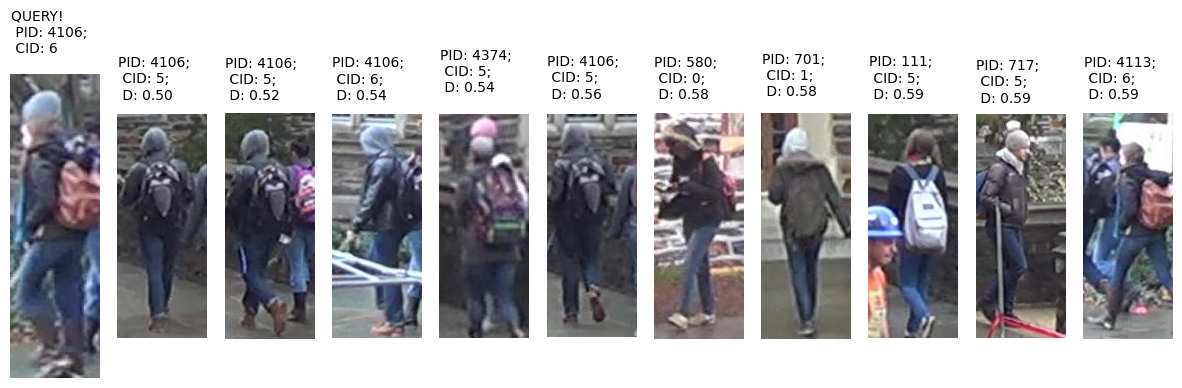

In [46]:
# Choose query index and top-k:
idx, k = 134, 10
D = distmat[idx, :]
D_ids = indices[idx, :k]
distances = D[indices[idx]]
print(distances[0], distances[-1])

gallery_paths = np.array(imgpaths)[qf.shape[0] + D_ids]
query_path = imgpaths[idx]

_, ax = plt.subplots(1, 1+k, figsize=(15, k))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(read_image(query_path))
ax[0].text(0, -15, f"QUERY! \n PID: {pids[idx]}; \n CID: {camids[idx]}")
[ax[i+1].imshow(read_image(gallery_paths[i])) for i in range(k)]
[ax[i+1].text(0, -15, f"PID: {pids[qf.shape[0] + D_ids[i]]}; \n CID: {camids[qf.shape[0] + D_ids[i]]}; \n D: {D[D_ids[i]]:.2f}") for i in range(k)]

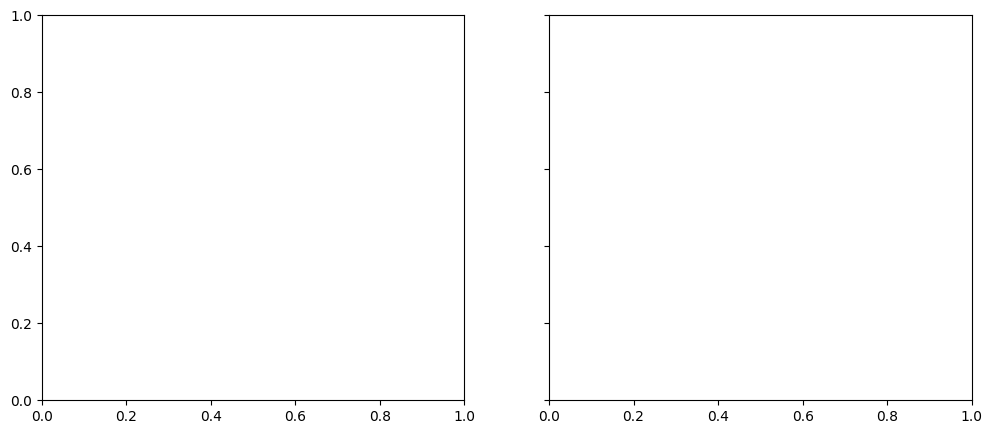

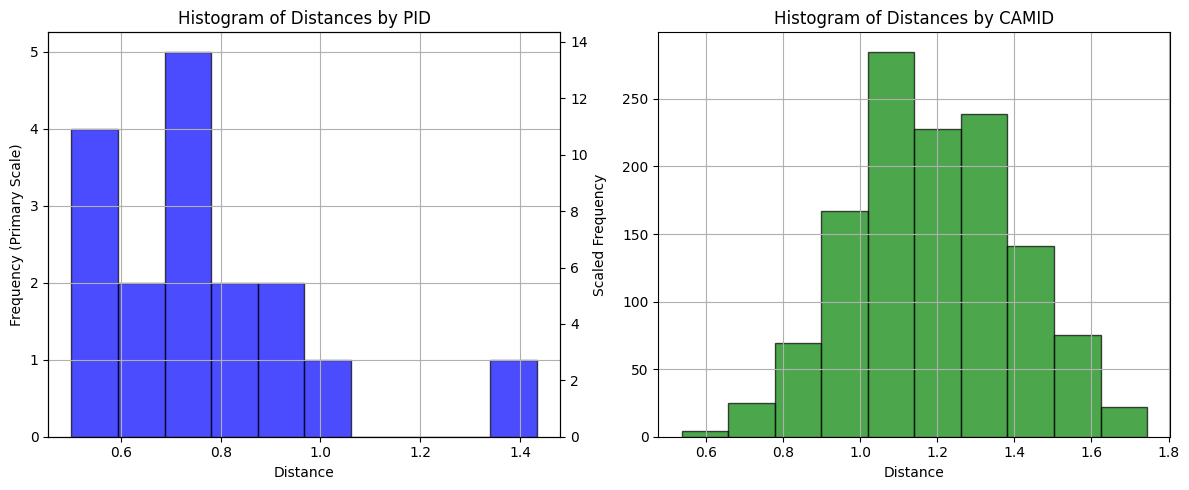

In [47]:
# Extract the necessary data
query_pid = pids[idx]
query_camid = camids[idx]

# Ensure D_ids is converted to the correct indices for gallery images
gallery_indices = qf.shape[0] + indices[idx]

# Extract gallery distances, pids, and camids
gallery_distances = distances
gallery_pids = np.array(pids)[gallery_indices]  # Correct array indexing
gallery_camids = np.array(camids)[gallery_indices]  # Correct array indexing

# Create histograms for pids and camids
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# print(gallery_pids.shape, query_pid)
# # Histogram for PID
# axs[0].hist(gallery_distances[gallery_pids == query_pid], bins=10, color='blue', alpha=0.7, edgecolor='black')
# axs[0].set_title("Histogram of Distances by PID")
# axs[0].set_xlabel("Distance")
# axs[0].set_ylabel("Frequency")
# axs[0].grid(True)

# # Add secondary y-axis for better scaling
# secondary_y = axs[0].twinx()
# secondary_y.set_ylabel("Scaled Frequency")
# secondary_y.set_ylim(0, max(pid_distances) * 10)  # Adjust scaling factor if needed

# # Histogram for CAMID
# axs[1].hist(gallery_distances[gallery_camids == query_camid], bins=10, color='green', alpha=0.7, edgecolor='black')
# axs[1].set_title("Histogram of Distances by CAMID")
# axs[1].set_xlabel("Distance")
# axs[1].grid(True)

# # Show the plots
# plt.tight_layout()
# plt.show()

# Filtered distances for histograms
pid_distances = gallery_distances[gallery_pids == query_pid]
camid_distances = gallery_distances[gallery_camids == query_camid]

# Create histograms for pids and camids
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=False)


# Histogram for PID
axs[0].hist(pid_distances, bins=10, color='blue', alpha=0.7, edgecolor='black')
axs[0].set_title("Histogram of Distances by PID")
axs[0].set_xlabel("Distance")
axs[0].set_ylabel("Frequency (Primary Scale)")
axs[0].grid(True)

# Add secondary y-axis for better scaling
secondary_y = axs[0].twinx()
secondary_y.set_ylabel("Scaled Frequency")
secondary_y.set_ylim(0, max(pid_distances) * 10)  # Adjust scaling factor if needed

# Histogram for CAMID
axs[1].hist(camid_distances, bins=10, color='green', alpha=0.7, edgecolor='black')
axs[1].set_title("Histogram of Distances by CAMID")
axs[1].set_xlabel("Distance")
axs[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()

torch.Size([11659, 768]) torch.Size([82161, 768]) (11659, 82161)
[   14    24     5 ... 44368 44401 19757]


100%|██████████| 11659/11659 [00:00<00:00, 404277.37it/s]

11659.0



/tmp/ipykernel_3485501/2925506742.py:10: RuntimeWarning: invalid value encountered in divide
  dists = dists / nums


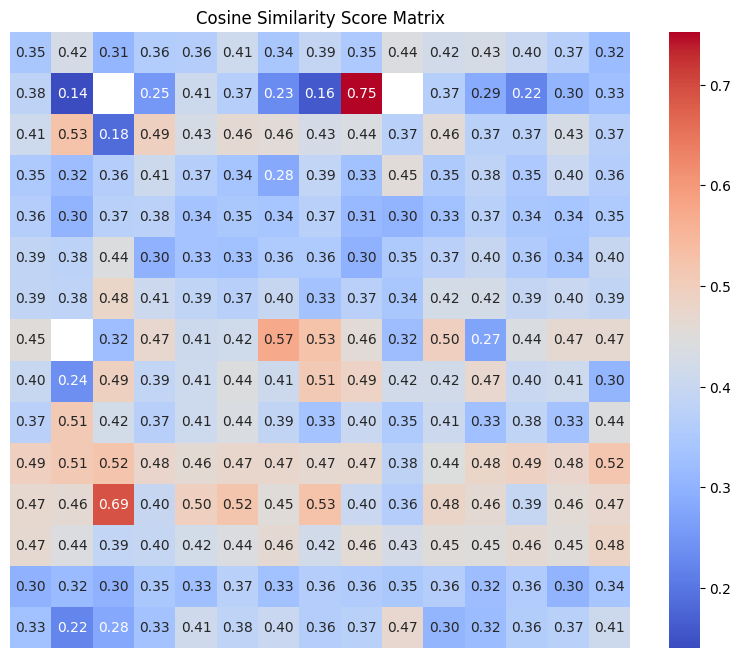

In [8]:
# mean distances per class
print(qf.shape, gf.shape, indices.shape)
print(indices[0])
nums, dists = np.zeros((15, 15)), np.zeros((15, 15))

for i in tqdm(range(qf.shape[0])):
    nums[camids[i], camids[indices[i][0]]] += 1
    dists[camids[i], camids[indices[i][0]]] += distmat[i][indices[i][0]]

dists = dists / nums
print(nums.sum())
make_heatmap(dists, "./outputs/train_msmt17_cam12345/distance_map.png")

In [20]:
pcount, ccount = 0, 0
dists = []
delta = 0
for i in tqdm(range(qf.shape[0]), total=qf.shape[0]):
    p = pids[i]
    c = camids[i]
    p_pred = pids[qf.shape[0] + indices[i, 0]]
    c_pred = camids[qf.shape[0] + indices[i, 0]]
    if p == p_pred: pcount += 1
    if c == c_pred: ccount += 1
    if p == p_pred and c == c_pred: 
        delta += 1
        continue
    dists.append(distmat[i, 0])
    #print(p, c, p_pred, c_pred, dists[-1])
    #if i == 10: break

pp = ((pcount - delta) / (qf.shape[0] - delta)) * 100.0
cp = ((ccount - delta) / (qf.shape[0] - delta)) * 100.0
print(f"Correct ID Percentage: {pp:.3f}, Matching camera percentage: {cp:.3f}")
dists = torch.tensor(dists)
print(f"Rank 1 Distance Stats: Min: {dists.min().item():.3f}, Max: {dists.max().item():.3f}, Mean: {dists.mean().item():.3f}, Std: {dists.std().item():.3f}")

100%|██████████| 11659/11659 [00:00<00:00, 421327.62it/s]

Correct ID Percentage: 34.609, Matching camera percentage: 51.914
Rank 1 Distance Stats: Min: 0.845, Max: 2.128, Mean: 1.637, Std: 0.178


In [2]:
from model.make_model_clipreid import *
from datasets.msmt17 import *
from datasets.bases import *
from config import cfg
from timm.data.random_erasing import RandomErasing
import clip
cfg.merge_from_file("configs/person/vit_clipreid.yml")
cfg.freeze()

train_transforms = T.Compose([
    T.Resize(cfg.INPUT.SIZE_TRAIN, interpolation=3),
    T.RandomHorizontalFlip(p=cfg.INPUT.PROB),
    T.Pad(cfg.INPUT.PADDING),
    T.RandomCrop(cfg.INPUT.SIZE_TRAIN),
    T.ToTensor(),
    T.Normalize(mean=cfg.INPUT.PIXEL_MEAN, std=cfg.INPUT.PIXEL_STD),
    RandomErasing(probability=cfg.INPUT.RE_PROB, mode='pixel', max_count=1, device='cpu'),
    # RandomErasing(probability=cfg.INPUT.RE_PROB, mean=cfg.INPUT.PIXEL_MEAN)
])

val_transforms = T.Compose([
    T.Resize(cfg.INPUT.SIZE_TEST),
    T.ToTensor(),
    T.Normalize(mean=cfg.INPUT.PIXEL_MEAN, std=cfg.INPUT.PIXEL_STD)
])

dataset = MSMT17('/export/livia/home/vision/Rbhattacharya/work/data/data/msmt17')
train_set = ImageDataset(dataset.train, val_transforms)

model = make_model(cfg, num_class=1041, camera_num=15, view_num = 5)
model.load_param("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/downloaded_models/MSMT17_clipreid_ViT-B-16_60.pth")
model.to('cuda')

clip_model = load_clip_to_cpu('ViT-B-16', model.h_resolution, model.w_resolution, model.vision_stride_size)
clip_model.to("cuda")


{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15} cam_container
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15} cam_container
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15} cam_container
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15} cam_container
=> MSMT17 loaded
Dataset statistics:
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |  1041 |    32621 |        15
  query    |  3060 |    11659 |        15
  gallery  |  3060 |    82161 |        15
  ----------------------------------------
=> MSMT17 statistics after trimming
Dataset statistics:
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |  1041 |    32621 |        15
  query    |  3060 |    11659 |        15
  gallery  |  3060 |    82161 |        15
  ----------------------------------------
Resized position embedding: %s to %s torch.Size([

/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/model/make_model_clipreid.py:214: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  param_dict = torch.load(t

Loading pretrained model from /export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/downloaded_models/MSMT17_clipreid_ViT-B-16_60.pth
Resized position embedding: %s to %s torch.Size([197, 768]) torch.Size([129, 768])
Position embedding resize to height:16 width: 8


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

tensor([[[0.4350]]], device='cuda:0', grad_fn=<UnsafeViewBackward0>) tensor([[[0.3779]]], device='cuda:0', grad_fn=<UnsafeViewBackward0>)


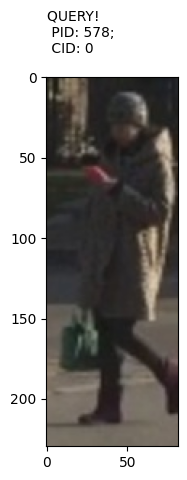

In [96]:
# Load-image
idx = 16542
img, seg_img, pid, camid, trackid, imgpath = train_set[idx]


k = 0
plt.imshow(read_image(imgpath))
plt.text(0, -15, f"QUERY! \n PID: {pid}; \n CID: {camid}")


imfeats = model(x=img.unsqueeze(0).cuda(), get_image=True)
tfeats = model(label=torch.tensor([pid]).cuda(), get_text=True)
# normalized features
image_features = imfeats / imfeats.norm(dim=-1, keepdim=True)
text_features = tfeats / tfeats.norm(dim=-1, keepdim=True)

N, C = image_features.size()
image_features = image_features.reshape(N, 1, C)
text_features = text_features.reshape(N, C, 1)

similarity = torch.matmul(image_features, text_features)


generic_text_prompt = clip.tokenize(["The image shows a person walking outdoors. They appear to be wearing a long coat, a hat, dark pants, and boots. The person is holding a pink object, possibly a phone, in one hand and carrying a green bag in the other. The image is somewhat blurred and taken from a distance, so finer details are not clear.. "]).to('cuda')
image_features = clip_model.encode_image(img.unsqueeze(0).cuda())[2]
text_features = clip_model.encode_text(generic_text_prompt)
image_features = image_features[:, 0, :]

# normalized features
image_features_norm = image_features / image_features.norm(dim=-1, keepdim=True)
text_features_norm = text_features / text_features.norm(dim=-1, keepdim=True)

N, C = image_features_norm.size()
image_features_norm = image_features_norm.reshape(N, 1, C)
text_features_norm = text_features_norm.reshape(N, C, 1)

similarity2 = torch.matmul(image_features_norm, text_features_norm)

print(similarity, similarity2)

In [3]:
qbins, gbins = {}, {}
for i in range(qf.shape[0]):
    if pids[i] in qbins: qbins[pids[i]].append(qf[i].unsqueeze(0))
    else: qbins[pids[i]] = [qf[i].unsqueeze(0)]

for i in range(gf.shape[0]):
    if pids[qf.shape[0] + i] in gbins: gbins[pids[qf.shape[0] + i]].append(gf[i].unsqueeze(0))
    else: gbins[pids[qf.shape[0] + i]] = [gf[i].unsqueeze(0)]

qnorms, gnorms = {}, {}
for k,v in qbins.items():
    qnorms[k] = [torch.cat(v, dim=0).mean(dim=0), torch.cat(v, dim=0).std(dim=0)]
for k,v in gbins.items():
    gnorms[k] = [torch.cat(v, dim=0).mean(dim=0), torch.cat(v, dim=0).std(dim=0)]

print(qnorms.keys(), gnorms.keys())

print(qnorms[537][1])

dict_keys([4427, 537, 90, 1366, 514, 543, 2012, 337, 758, 46, 4774, 757, 444, 542, 300, 468, 395, 274, 400, 241, 806, 4110, 4693, 551, 294, 80, 223, 243, 103, 527, 3731, 341, 68, 4152, 51, 581, 830, 1403, 4249, 4284, 4065, 746, 4480, 183, 3609, 371, 412, 19, 626, 359, 3201, 204, 4699, 1108, 2777, 4190, 4736, 4060, 162, 295, 43, 765, 31, 838, 4366, 66, 215, 1626, 599, 4066, 603, 2495, 119, 361, 620, 4494, 442, 21, 1642, 651, 591, 555, 824, 1398, 4633, 205, 4335, 1518, 560, 501, 358, 150, 1487, 663, 1901, 2736, 4613, 711, 698, 4332, 1723, 1297, 4113, 75, 703, 4708, 269, 4178, 293, 287, 601, 159, 1834, 4170, 4596, 69, 1699, 187, 163, 631, 4459, 1290, 4760, 98, 288, 4075, 4106, 700, 540, 570, 4121, 3674, 249, 206, 4204, 652, 552, 460, 722, 106, 516, 30, 812, 334, 4144, 741, 4727, 773, 674, 427, 4405, 594, 1750, 33, 4558, 1104, 760, 4326, 685, 304, 95, 4634, 500, 363, 499, 4117, 455, 1893, 426, 4380, 235, 316, 453, 1490, 221, 586, 4114, 76, 79, 4416, 4443, 694, 648, 4640, 4176, 301, 53, 456

In [7]:
from collections import Counter


qbins, gbins = {}, {}
qpids, gpids = {}, {}
for i in range(qf.shape[0]):
    if camids[i] in qbins: 
        qbins[camids[i]].append(qf[i].unsqueeze(0))
        qpids[camids[i]].append(pids[i])
    else: 
        qbins[camids[i]] = [qf[i].unsqueeze(0)]
        qpids[camids[i]] = [pids[i]]

for i in range(gf.shape[0]):
    if camids[qf.shape[0] + i] in gbins: 
        gbins[camids[qf.shape[0] + i]].append(gf[i].unsqueeze(0))
        gpids[camids[qf.shape[0] + i]].append(pids[qf.shape[0] + i])
    else: 
        gbins[camids[qf.shape[0] + i]] = [gf[i].unsqueeze(0)]
        gpids[camids[qf.shape[0] + i]] = [pids[qf.shape[0] + i]]

qnorms, gnorms = {}, {}
for k,v in qbins.items():
    qnorms[k] = [torch.cat(v, dim=0).mean(dim=0), torch.cat(v, dim=0).std(dim=0)]
for k,v in gbins.items():
    gnorms[k] = [torch.cat(v, dim=0).mean(dim=0), torch.cat(v, dim=0).std(dim=0)]

print(qnorms.keys(), gnorms.keys())

for k,v in qnorms.items():
    IDS = qpids[k]
    frequency_dict = Counter(IDS)
    frequency_dict = dict(frequency_dict)
    print(k, len(qbins[k]), frequency_dict)
    print(v[0])
    print(v[1])
    

dict_keys([5, 0, 1, 3, 6, 4, 7, 2]) dict_keys([4, 7, 1, 3, 5, 0, 6, 2])
5 369 {4427: 1, 514: 1, 4774: 1, 757: 1, 4110: 1, 551: 1, 3731: 1, 4152: 1, 4249: 1, 4284: 1, 19: 1, 4190: 1, 4736: 1, 295: 1, 43: 1, 1403: 1, 119: 1, 21: 1, 4633: 1, 4613: 1, 711: 1, 4332: 1, 703: 1, 4178: 1, 159: 1, 4596: 1, 361: 1, 4065: 1, 163: 1, 98: 1, 3674: 1, 33: 1, 4326: 1, 4634: 1, 500: 1, 4380: 1, 235: 1, 591: 1, 76: 1, 4416: 1, 292: 1, 4185: 1, 5842: 1, 241: 1, 360: 1, 140: 1, 243: 1, 4159: 1, 72: 1, 379: 1, 4144: 1, 468: 1, 4271: 1, 4226: 1, 200: 1, 4727: 1, 4494: 1, 3664: 1, 2454: 1, 329: 1, 270: 1, 359: 1, 4758: 1, 2942: 1, 4695: 1, 4082: 1, 4075: 1, 4219: 1, 1108: 1, 4329: 1, 3618: 1, 2471: 1, 4158: 1, 4118: 1, 4750: 1, 4197: 1, 4477: 1, 4572: 1, 4255: 1, 4134: 1, 4163: 1, 743: 1, 4331: 1, 4247: 1, 4221: 1, 3354: 1, 4459: 1, 4146: 1, 444: 1, 515: 1, 4510: 1, 4760: 1, 6535: 1, 4280: 1, 542: 1, 469: 1, 583: 1, 1463: 1, 494: 1, 4071: 1, 828: 1, 4757: 1, 4373: 1, 4540: 1, 410: 1, 1775: 1, 212: 1, 405: 1

In [33]:
f1 = qbins[5][0]
f2 = qbins[6][207]
f3 = qbins[7][172]
f4 = qbins[1][2]
ed_12 = euclidean_distance(f1, f2)
ed_23 = euclidean_distance(f2, f3)
ed_13 = euclidean_distance(f1, f3)
ed_14 = euclidean_distance(f1, f4)
ed_24 = euclidean_distance(f2, f4)
ed_34 = euclidean_distance(f3, f4)
print(ed_12, ed_23, ed_13, ed_14, ed_24, ed_34)

[[0.54330075]] [[0.4287449]] [[0.5042602]] [[1.5410924]] [[1.4376857]] [[1.491387]]


/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/utils/metrics.py:16: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta = 1, Number alpha = 1) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1581.)
  dist_mat.addmm_(1, -2, qf, gf.t())


(2228, 17661)


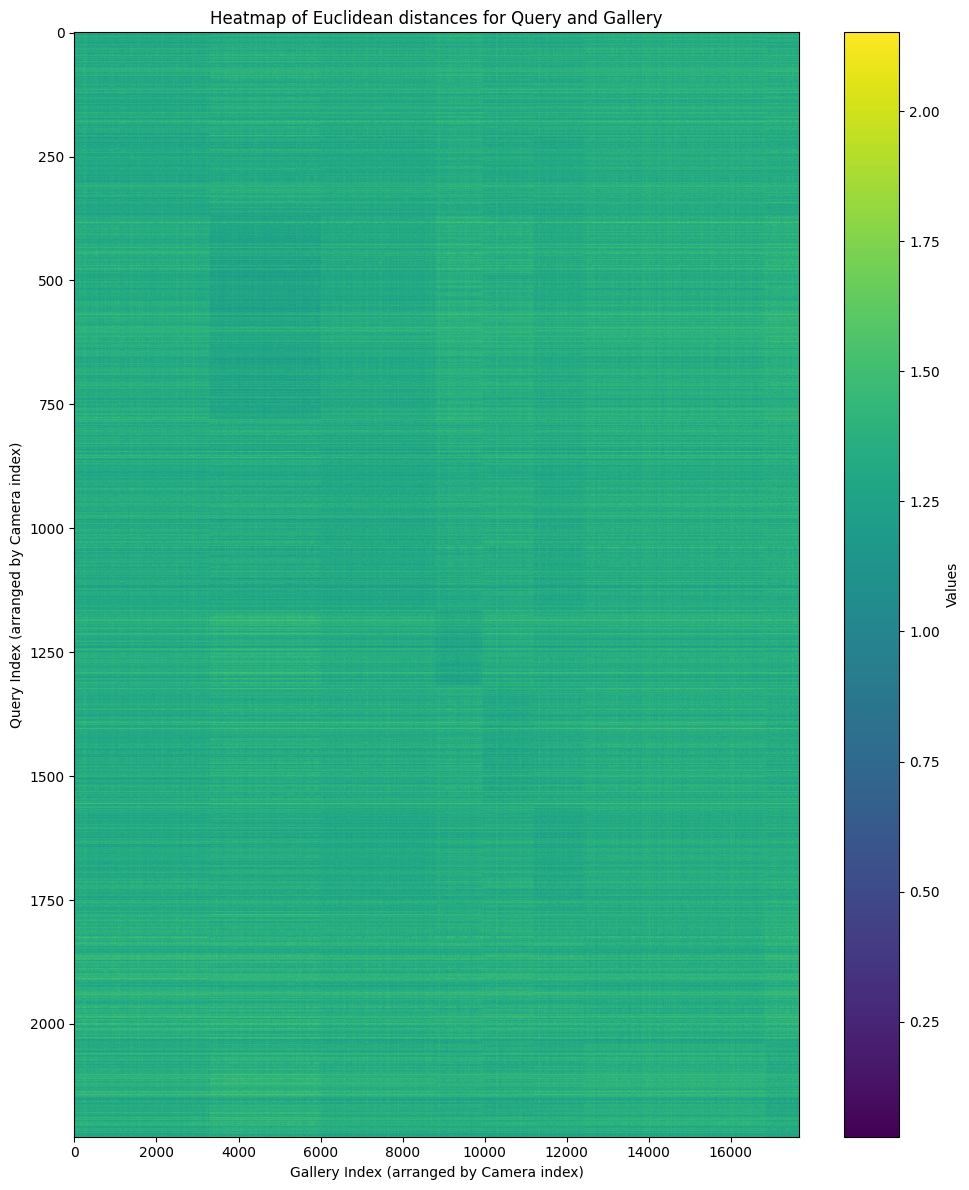

In [5]:
QLIST = []
GLIST = []
x_lines, y_lines = [], []
for k,v in qbins.items():
    QLIST += v
    GLIST += gbins[k]
    if len(x_lines) == 0: 
        x_lines.append(len(v))
        y_lines.append(len(gbins[k]))
    else: 
        x_lines.append(x_lines[-1] + len(v))
        y_lines.append(y_lines[-1] + len(gbins[k]))
QLIST = torch.cat(QLIST, dim=0)
GLIST = torch.cat(GLIST, dim=0)
QED = euclidean_distance(QLIST, GLIST)
print(QED.shape)
#print(QED)

# Example QED matrix (Replace with your actual data)
# QED = np.random.random((2228, 2228))  # Random data for demonstration

# Specify line locations
#x_lines = [369, , 1000, 1500]  # Example horizontal line positions
#y_lines = x_lines   # Example vertical line positions

# Create the heatmap
plt.figure(figsize=(10, 12))  # Adjust figure size for better visualization
plt.imshow(QED, cmap='viridis', aspect='auto')  # Display the heatmap

# Add the lines
# for x in x_lines[:-1]:
#     plt.axhline(y=x, color='black', linestyle='dotted', linewidth=0.8)  # Horizontal lines

# for y in y_lines[:-1]:
#     plt.axvline(x=y, color='black', linestyle='dotted', linewidth=0.8)  # Vertical lines

# Add colorbar and labels
plt.colorbar(label='Values')
plt.title('Heatmap of Euclidean distances for Query and Gallery')
plt.xlabel('Gallery Index (arranged by Camera index)')
plt.ylabel('Query Index (arranged by Camera index)')

# Display the plot
plt.tight_layout()
plt.show()

In [6]:
# fetch from bins

query_feats, gallery_feats = qf, gf
PIDS, CIDS = pids, camids
print(qf.shape, gf.shape, indices.shape)
evaluator = R1_mAP_eval(num_query=query_feats.shape[0], max_rank=50, feat_norm=True)
feats = torch.cat([query_feats, gallery_feats], dim=0)
evaluator.feats = feats
evaluator.pids = PIDS
evaluator.camids = CIDS
cmc, mAP, _, _, _, _, _ = evaluator.compute()
print(mAP)
print(cmc[0], cmc[4], cmc[9], cmc[49])

torch.Size([2228, 1280]) torch.Size([17661, 1280]) (2228, 17661)
The test feature is normalized
=> Computing DistMat with euclidean_distance


100%|██████████| 2228/2228 [00:00<00:00, 2763.96it/s]

0.571007399417207
0.7387792 0.8559246 0.88734293 0.93177736


In [9]:
print(gnorms[1][0].shape)

torch.Size([1280])


In [10]:
# Test time adapter:

class TestTimeAdapter(nn.Module):
    def __init__(self, dims, gallery_feats, gallery_camids, steps=1, device='cuda:1', lr=0.0005, topk=50):
        super(TestTimeAdapter, self).__init__()
        self.gallery_feats = gallery_feats
        self.gallery_camids = gallery_camids
        self.gnorms = gnorms
        self.qnorms = qnorms
        
        self.steps = steps
        self.lr = lr
        self.topk = topk
        self.reset()
        self.device = device
        
        
    def loss(self, q, g):
        S = euclidean_distance(q, g, return_tensor=True)
        loss = 0.0
        for i in range(S.shape[0]):
            s = S[i]
            # Find the indices of the k smallest values
            _, topk_indices = torch.topk(s, self.topk, largest=False)
            # Create a mask with all False
            mask = torch.zeros_like(s, dtype=torch.bool)
            # Set True for top-k smallest indices
            mask[topk_indices] = True
            # Set all non-top-k elements to zero (or another value)
            s[~mask] = 0  # In-place operation
            loss += s.sum()
        return loss
    
    def reset(self):
        self.param_list = []
        for k,v in self.gnorms.items():
            #self.gnorms[k] = [v[0], v[1]]
            self.gnorms[k] = [torch.nn.Parameter(v[0]), torch.nn.Parameter(v[1])]
            #self.qnorms[k] = [torch.nn.Parameter(qnorms[k][0]), torch.nn.Parameter(qnorms[k][1])]
            self.qnorms[k] = [qnorms[k][0], qnorms[k][1]]
            self.param_list.append(self.gnorms[k][0])
            self.param_list.append(self.gnorms[k][1])
            # self.param_list.append(self.qnorms[k][0])
            # self.param_list.append(self.qnorms[k][1])
        self.optimizer = torch.optim.Adam(params=self.param_list, lr=self.lr, weight_decay=1e-4)

    def forward(self, x, camids, episodic=True):
        for i in range(self.steps):
            self.optimizer.zero_grad()
            g = self.gallery_feats
            # Gallery normalization
            means, stds = [], []
            for i in self.gallery_camids:
                means.append(self.gnorms[i][0])
                stds.append(self.gnorms[i][1])
            means = torch.stack(means)
            stds = torch.stack(stds)
            gf_norm = (g - means.to(self.device)) / stds.to(self.device)

            # Query normalization
            means, stds = [], []
            for i in camids:
                means.append(self.qnorms[i][0])
                stds.append(self.qnorms[i][1])
            means = torch.stack(means)
            stds = torch.stack(stds)
            x = (x - means.to(self.device)) / stds.to(self.device)
            
            loss = self.loss(x, gf_norm)
            loss.backward()
            self.optimizer.step()
        if episodic: self.reset()

        return x, gf_norm
    


In [11]:
adapter = TestTimeAdapter(dims=1280, gallery_feats=gf.to('cuda:1'), gallery_camids=camids[qf.shape[0]:], steps=1, lr=0.0005, topk=50).to('cuda:1')

qf_new = []
for i in tqdm(range(qf.shape[0])):
    q = qf[i].unsqueeze(0).to('cuda:1')
    c = camids[i]
    q, g = adapter(q, [c])
    qf_new.append(q[0].detach().cpu())
    gf_new = g.detach().cpu()
qf_new = torch.stack(qf_new)
# fetch from bins

query_feats, gallery_feats = qf_new, gf_new
PIDS, CIDS = pids, camids
print(qf.shape, gf.shape, indices.shape)
evaluator = R1_mAP_eval(num_query=query_feats.shape[0], max_rank=50, feat_norm=True)
feats = torch.cat([query_feats, gallery_feats], dim=0)
evaluator.feats = feats
evaluator.pids = PIDS
evaluator.camids = CIDS
cmc, mAP, _, _, _, _, _ = evaluator.compute()
print(mAP)
print(cmc[0], cmc[4], cmc[9], cmc[49])

  0%|          | 0/2228 [00:00<?, ?it/s]

 43%|████▎     | 957/2228 [04:48<06:22,  3.32it/s]


KeyboardInterrupt: 

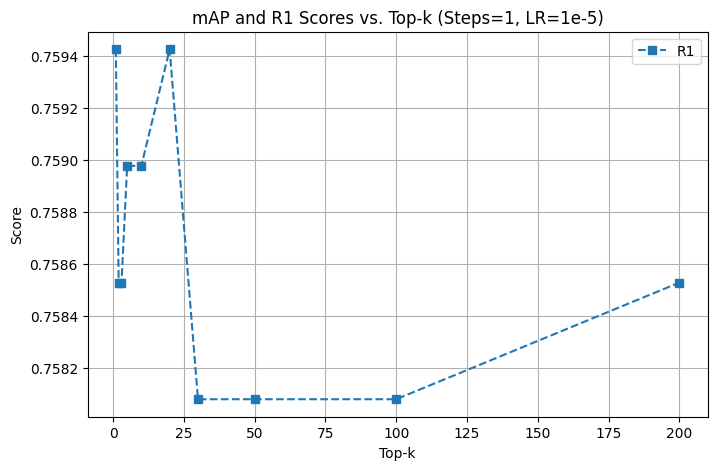

In [3]:
import matplotlib.pyplot as plt

# Data
topk_values = [1, 2, 3, 5, 10, 20, 30, 50, 100, 200]
mAP_values = [0.593847, 0.593817, 0.593804, 0.593946, 0.594130, 0.594149, 0.594133, 0.594046, 0.594006, 0.593935]
R1_values = [0.759426, 0.758528, 0.758528, 0.758977, 0.758977, 0.759426, 0.758079, 0.758079, 0.758079, 0.758528]

# Create the plot
plt.figure(figsize=(8, 5))
#plt.plot(topk_values, mAP_values, marker='o', linestyle='-', label='mAP')
plt.plot(topk_values, R1_values, marker='s', linestyle='--', label='R1')

# Labels and title
plt.xlabel("Top-k")
plt.ylabel("Score")
plt.title("mAP and R1 Scores vs. Top-k (Steps=1, LR=1e-5)")
plt.legend()
plt.grid(True)

# Show plot
plt.show()
